# Crearemos una función para graficar anotaciones por jugador

In [1]:
import urllib.request
import ssl
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt

from matplotlib.offsetbox import  OffsetImage
from matplotlib.patches import Circle, Rectangle, Arc
from nba_api.stats.endpoints import shotchartdetail

In [2]:
#parámetros
p_id = 2544
season = '2016-17'
# 'Playoffs' o 'Reguar Season'
gametype = 'Playoffs'

In [3]:
def AnotacionesJugador(p_id, season, gametype):
    
    def draw_court(ax=None, color='black', lw=2, outer_lines=False):
        # If an axes object isn't provided to plot onto, just get current one
        if ax is None:
            ax = plt.gca()

        # Create the various parts of an NBA basketball court

        # Create the basketball hoop
        # Diameter of a hoop is 18" so it has a radius of 9", which is a value
        # 7.5 in our coordinate system
        hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

        # Create backboard
        backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

        # The paint
        # Create the outer box 0f the paint, width=16ft, height=19ft
        outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                              fill=False)
        # Create the inner box of the paint, widt=12ft, height=19ft
        inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                              fill=False)

        # Create free throw top arc
        top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                             linewidth=lw, color=color, fill=False)
        # Create free throw bottom arc
        bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                                linewidth=lw, color=color, linestyle='dashed')
        # Restricted Zone, it is an arc with 4ft radius from center of the hoop
        restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                         color=color)

        # Three point line
        # Create the side 3pt lines, they are 14ft long before they begin to arc
        corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                                   color=color)
        corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        # I just played around with the theta values until they lined up with the 
        # threes
        three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                        color=color)

        # Center Court
        center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                               linewidth=lw, color=color)
        center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                               linewidth=lw, color=color)

        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]

        if outer_lines:
            # Draw the half court line, baseline and side out bound lines
            outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                    color=color, fill=False)
            court_elements.append(outer_lines)

        # Add the court elements onto the axes
        for element in court_elements:
            ax.add_patch(element)

        return ax
    
    response = shotchartdetail.ShotChartDetail(
    team_id = 0,
    player_id = p_id,
    season_nullable = season,
    season_type_all_star = gametype)

    content = json.loads(response.get_json())
    
    # transform contents into dataframe
    results = content['resultSets'][0]
    headers = results['headers']
    rows = results['rowSet']
    shot_df = pd.DataFrame(rows)
    shot_df.columns = headers
    
    ssl._create_default_https_context = ssl._create_unverified_context
    # we pass in the link to the image as the 1st argument
    pic = urllib.request.urlretrieve(f"http://stats.nba.com/media/players/230x185/{p_id}.png",
                                    f"{p_id}.png")

    # urlretrieve returns a tuple with our image as the first 
    # element and imread reads in the image as a 
    # mutlidimensional numpy array so matplotlib can plot it
    harden_pic = plt.imread(pic[0])
    
    
    # get our colormap for the main kde plot
    # Note we can extract a color from cmap to use for 
    # the plots that lie on the side and top axes
    cmap = plt.cm.gist_heat_r

    # n_levels sets the number of contour lines for the main kde plot
    joint_shot_chart = sns.jointplot(shot_df.LOC_X, shot_df.LOC_Y, stat_func=None,
                                     kind='kde', space=0, color=cmap(0.1),
                                     cmap=cmap, n_levels=50)

    joint_shot_chart.fig.set_size_inches(12,11)

    # A joint plot has 3 Axes, the first one called ax_joint, 
    # It's the one we want to draw our court onto and adjust some other settings
    ax = joint_shot_chart.ax_joint
    draw_court(ax, color="gray", lw=1)

    # Adjust the axis limits and orientation of the plot in order
    # to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')

    # Add a title
    ax.set_title('James Harden FGA \n2014-15 Reg. Season', 
                 y=1.2, fontsize=18)

    # Add Data Scource and Author
    ax.text(-250,445,'Data Source: stats.nba.com', fontsize=12)

    # Add Harden's image to the top right
    # First create our OffSetImage by passing in our image
    # and set the zoom level to make the image small enough 
    # to fit on our plot
    img = OffsetImage(harden_pic, zoom=0.6)
    # Pass in a tuple of x,y coordinates to set_offset
    # to place the plot where you want, I just played around
    # with the values until I found a spot where I wanted
    # the image to be
    img.set_offset((625,621))
    # add the image
    ax.add_artist(img)

    plt.show()

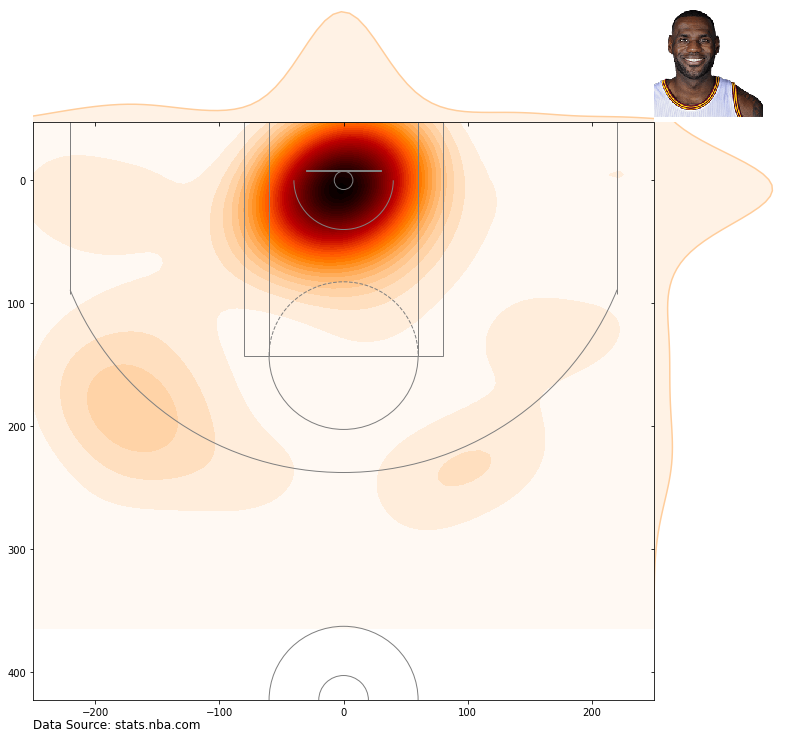

In [4]:
AnotacionesJugador(p_id, season, gametype)